## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import time
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from cuml.ensemble import RandomForestRegressor as cuRF
from scripts.function_utils import last_energy_points, predict_results, prepare_polynomial, normalize_training, expanding_window_split, retrieve_selected_features, total_averaged_metrics, no_ml_predict

## Load Data

In [2]:
df = pd.read_csv("../../data/loureiro_45houses.csv")
number_of_houses = len(df.columns) - 1
df

,Time,Energy_1,Energy_2,Energy_9,Energy_11,Energy_15,Energy_16,Energy_17,Energy_29,Energy_30,...,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.114,0.164,0.072,0.055,0.011,0.006,...,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004,0.008
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.190,0.135,0.058,0.060,0.002,0.006,...,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003,0.056
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.180,0.121,0.011,0.096,0.010,0.006,...,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004,0.033
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.167,0.138,0.010,0.064,0.004,0.006,...,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004,0.062
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.133,0.104,0.011,0.072,0.002,0.006,...,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2023-06-05 10:45:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38012,2023-06-05 11:00:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38013,2023-06-05 11:15:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38014,2023-06-05 11:30:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028


In [3]:
df_total = pd.DataFrame(df.drop(["Time"],axis=1).sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,3.231
1,3.043
2,2.959
3,3.067
4,2.987
...,...
38011,4.150
38012,4.149
38013,4.150
38014,4.179


#### Example of past timesteps

In [4]:
Xt, yt = last_energy_points(df_total, 3)
Xt

,lag_1,lag_2,lag_3
0,2.959,3.043,3.231
1,3.067,2.959,3.043
2,2.987,3.067,2.959
3,3.755,2.987,3.067
4,3.129,3.755,2.987
...,...,...,...
38008,4.149,4.168,4.179
38009,4.150,4.149,4.168
38010,4.149,4.150,4.149
38011,4.150,4.149,4.150


In [5]:
Xt_norm, _ = normalize_training(Xt)
Xt_norm

array([[0.21524696, 0.22135739, 0.2350331 ],
       [0.22310322, 0.21524696, 0.22135739],
       [0.21728377, 0.22310322, 0.21524696],
       ...,
       [0.3018113 , 0.30188405, 0.3018113 ],
       [0.30188405, 0.3018113 , 0.30188405],
       [0.3039936 , 0.30188405, 0.3018113 ]])

In [6]:
yt

,Energy
0,3.067
1,2.987
2,3.755
3,3.129
4,2.836
...,...
38008,4.150
38009,4.149
38010,4.150
38011,4.179


# No ML

In [7]:
X15 = df_total.copy()
X15 = X15.iloc[:-1]
X15.reset_index(drop=True, inplace=True)
X15

,Energy
0,3.231
1,3.043
2,2.959
3,3.067
4,2.987
...,...
38010,4.149
38011,4.150
38012,4.149
38013,4.150


In [8]:
y15 = df_total.copy()
y15 = y15.iloc[1:]
y15.reset_index(drop=True, inplace=True)
y15

,Energy
0,3.043
1,2.959
2,3.067
3,2.987
4,3.755
...,...
38010,4.150
38011,4.149
38012,4.150
38013,4.179


In [9]:
rmse_15, wape_15, r2_15 = no_ml_predict(X15.values, y15.values)

RMSE: 0.5377
WAPE: 10.48
R2: 0.8542


# Linear Regression

### Test for last day

In [10]:
number_of_past_timesteps = 96

In [11]:
n_splits = 10

In [12]:
metrics_list_lr = []

X, y = last_energy_points(df_total, number_of_past_timesteps)

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, LinearRegression())
    metrics_list_lr.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 0.4288
WAPE: 9.14
R2: 0.8385

Elapsed time: 0.041 seconds

Iteration  1
RMSE: 0.4335
WAPE: 8.64
R2: 0.8416

Elapsed time: 0.044 seconds

Iteration  2
RMSE: 0.4180
WAPE: 8.91
R2: 0.8385

Elapsed time: 0.027 seconds

Iteration  3
RMSE: 0.4704
WAPE: 10.09
R2: 0.8585

Elapsed time: 0.040 seconds

Iteration  4
RMSE: 0.4978
WAPE: 9.53
R2: 0.8882

Elapsed time: 0.040 seconds

Iteration  5
RMSE: 0.5580
WAPE: 9.35
R2: 0.8993

Elapsed time: 0.049 seconds

Iteration  6
RMSE: 0.5878
WAPE: 9.95
R2: 0.8830

Elapsed time: 0.053 seconds

Iteration  7
RMSE: 0.6158
WAPE: 10.86
R2: 0.8556

Elapsed time: 0.063 seconds

Iteration  8
RMSE: 0.5085
WAPE: 11.00
R2: 0.8303

Elapsed time: 0.101 seconds

Iteration  9
RMSE: 0.4655
WAPE: 10.13
R2: 0.8150

Elapsed time: 0.083 seconds


In [13]:
rmse_lr, wape_lr, r2_lr = total_averaged_metrics(metrics_list_lr)

Total Averaged RMSE: 0.498
Total Averaged WAPE: 9.76
Total Averaged R2: 0.855


In [14]:
col1 = [row[0] for row in metrics_list_lr]
col2 = [row[1] for row in metrics_list_lr]
col3 = [row[2] for row in metrics_list_lr]

Text(0.5, 0, 'EW Iterations')

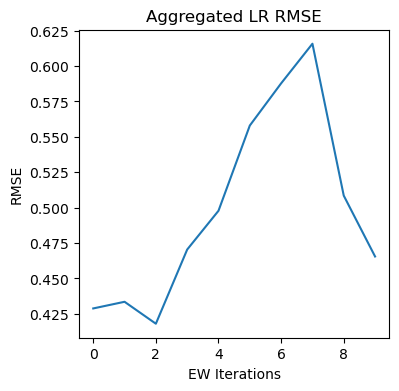

In [15]:
plt.figure(figsize=(4, 4)) 
plt.plot(col1)
plt.title('Aggregated LR RMSE')
plt.ylabel('RMSE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

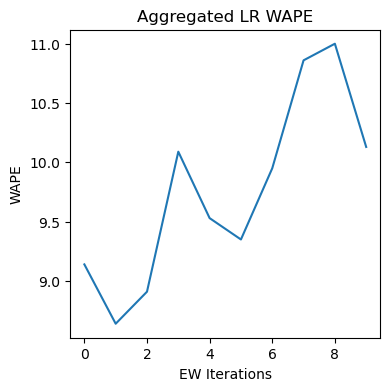

In [16]:
plt.figure(figsize=(4, 4)) 
plt.plot(col2)
plt.title('Aggregated LR WAPE')
plt.ylabel('WAPE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

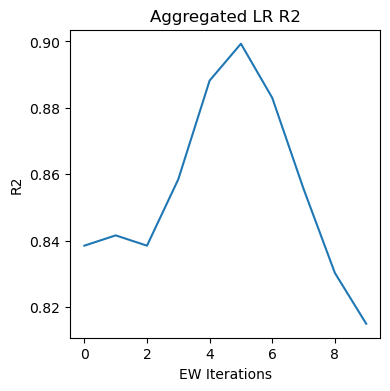

In [17]:
plt.figure(figsize=(4, 4)) 
plt.plot(col3)
plt.title('Aggregated LR R2')
plt.ylabel('R2')
plt.xlabel('EW Iterations')

# XGBoost

In [18]:
metrics_list_xgb = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, model_xgb = predict_results(X_train_norm, X_test_norm, y_train, y_test, xgb.XGBRegressor(seed=42, tree_method='gpu_hist'))
    metrics_list_xgb.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 0.4868
WAPE: 10.04
R2: 0.7919

Elapsed time: 3.190 seconds

Iteration  1
RMSE: 0.4630
WAPE: 9.24
R2: 0.8192

Elapsed time: 0.144 seconds

Iteration  2
RMSE: 0.4302
WAPE: 9.18
R2: 0.8289

Elapsed time: 0.145 seconds

Iteration  3
RMSE: 0.5260
WAPE: 11.25
R2: 0.8231

Elapsed time: 0.151 seconds

Iteration  4
RMSE: 0.5639
WAPE: 10.66
R2: 0.8566

Elapsed time: 0.158 seconds

Iteration  5
RMSE: 0.6456
WAPE: 10.49
R2: 0.8652

Elapsed time: 0.160 seconds

Iteration  6
RMSE: 0.6454
WAPE: 10.58
R2: 0.8590

Elapsed time: 0.171 seconds

Iteration  7
RMSE: 0.6360
WAPE: 11.29
R2: 0.8460

Elapsed time: 0.171 seconds

Iteration  8
RMSE: 0.5144
WAPE: 11.13
R2: 0.8264

Elapsed time: 0.178 seconds

Iteration  9
RMSE: 0.4670
WAPE: 10.13
R2: 0.8139

Elapsed time: 0.183 seconds


In [19]:
rmse_xgb, wape_xgb, r2_xgb = total_averaged_metrics(metrics_list_xgb)

Total Averaged RMSE: 0.538
Total Averaged WAPE: 10.399
Total Averaged R2: 0.833


In [20]:
col1 = [row[0] for row in metrics_list_xgb]
col2 = [row[1] for row in metrics_list_xgb]
col3 = [row[2] for row in metrics_list_xgb]

Text(0.5, 0, 'EW Iterations')

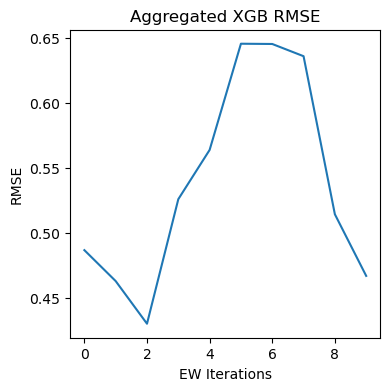

In [21]:
plt.figure(figsize=(4, 4)) 
plt.plot(col1)
plt.title('Aggregated XGB RMSE')
plt.ylabel('RMSE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

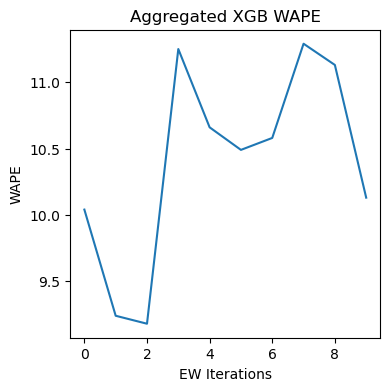

In [22]:
plt.figure(figsize=(4, 4)) 
plt.plot(col2)
plt.title('Aggregated XGB WAPE')
plt.ylabel('WAPE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

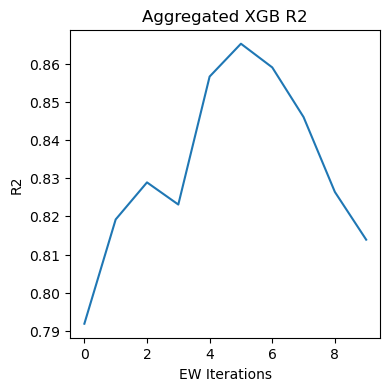

In [23]:
plt.figure(figsize=(4, 4)) 
plt.plot(col3)
plt.title('Aggregated XGB R2')
plt.ylabel('R2')
plt.xlabel('EW Iterations')

# Random Forest

In [24]:
metrics_list_rf = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, cuRF())
    metrics_list_rf.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4458
WAPE: 9.26
R2: 0.8255

Elapsed time: 0.563 seconds

Iteration  1
RMSE: 0.4376
WAPE: 8.69
R2: 0.8385

Elapsed time: 0.665 seconds

Iteration  2


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4121
WAPE: 8.78
R2: 0.8430

Elapsed time: 0.785 seconds

Iteration  3
RMSE: 0.4713
WAPE: 10.21
R2: 0.8580

Elapsed time: 0.905 seconds

Iteration  4


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.5257
WAPE: 9.90
R2: 0.8753

Elapsed time: 1.004 seconds

Iteration  5
RMSE: 0.6193
WAPE: 10.07
R2: 0.8759

Elapsed time: 1.112 seconds

Iteration  6


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.6148
WAPE: 10.13
R2: 0.8720

Elapsed time: 1.216 seconds

Iteration  7
RMSE: 0.6122
WAPE: 10.90
R2: 0.8573

Elapsed time: 1.307 seconds

Iteration  8


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4972
WAPE: 10.86
R2: 0.8378

Elapsed time: 1.375 seconds

Iteration  9
RMSE: 0.4556
WAPE: 9.93
R2: 0.8228

Elapsed time: 1.451 seconds


In [25]:
rmse_rf, wape_rf, r2_rf = total_averaged_metrics(metrics_list_rf)

Total Averaged RMSE: 0.509
Total Averaged WAPE: 9.873
Total Averaged R2: 0.851


In [26]:
col1 = [row[0] for row in metrics_list_rf]
col2 = [row[1] for row in metrics_list_rf]
col3 = [row[2] for row in metrics_list_rf]

Text(0.5, 0, 'EW Iterations')

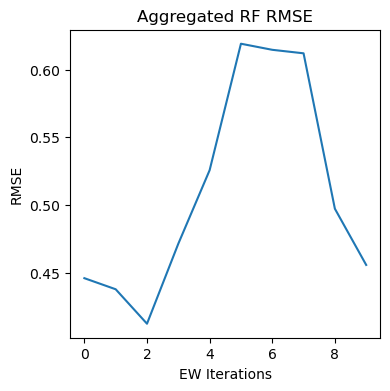

In [27]:
# Plot for the first column
plt.figure(figsize=(4, 4)) # 1 row, 3 columns, 1st position
plt.plot(col1)
plt.title('Aggregated RF RMSE')
plt.ylabel('RMSE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

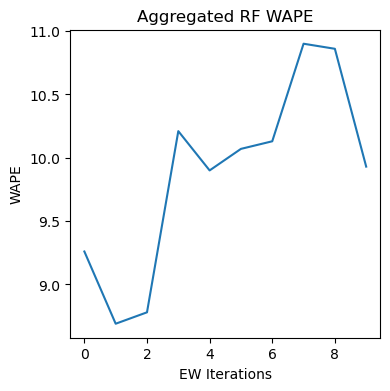

In [28]:
# Plot for the second column
plt.figure(figsize=(4, 4))
plt.title('Aggregated RF WAPE')
plt.plot(col2)
plt.ylabel('WAPE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

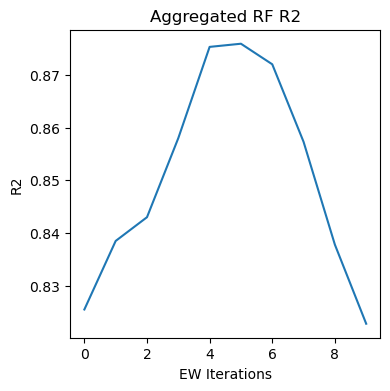

In [29]:
# Plot for the third column
plt.figure(figsize=(4, 4))
plt.title('Aggregated RF R2')
plt.plot(col3)
plt.ylabel('R2')
plt.xlabel('EW Iterations')

# Feature Selection

<Axes: >

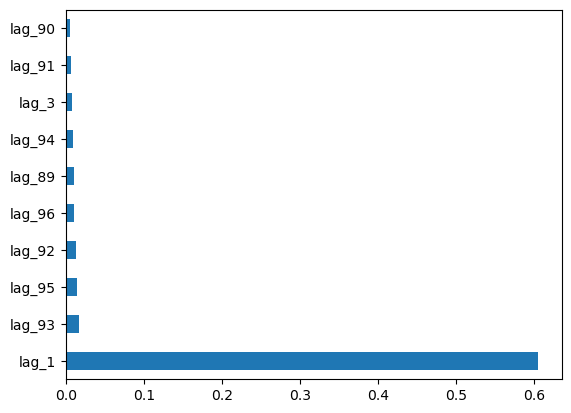

In [30]:
feature_importance = pd.Series(model_xgb.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')

In [31]:
features = feature_importance.nlargest(10).index
X_selected = X.loc[:,features]
X_selected

,lag_1,lag_93,lag_95,lag_92,lag_96,lag_89,lag_94,lag_3,lag_91,lag_90
0,2.912,3.067,3.043,2.987,3.231,2.836,2.959,3.0135,3.755,3.129
1,2.863,2.987,2.959,3.755,3.043,2.748,3.067,2.5140,3.129,2.836
2,3.503,3.755,3.067,3.129,2.959,3.057,2.987,2.9120,2.836,2.748
3,4.067,3.129,2.987,2.836,3.067,3.566,3.755,2.8630,2.748,3.057
4,3.941,2.836,3.755,2.748,2.987,3.003,3.129,3.5030,3.057,3.566
...,...,...,...,...,...,...,...,...,...,...
37915,4.149,4.887,4.354,4.525,4.978,4.639,5.659,4.1790,3.870,4.510
37916,4.150,4.525,5.659,3.870,4.354,5.718,4.887,4.1680,4.510,4.639
37917,4.149,3.870,4.887,4.510,5.659,5.249,4.525,4.1490,4.639,5.718
37918,4.150,4.510,4.525,4.639,4.887,4.846,3.870,4.1500,5.718,5.249


# Hyper-parameter tuning

In [32]:
params_xgb = { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7],
}

In [33]:
params_rf = {
    'max_depth': [3, 8, 16],
    'max_batch_size': [2, 32, 64],
    'min_samples_split': [2, 10],
    'n_estimators': [250, 500]
}

In [ ]:
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist", seed=42)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 5, n_jobs = 4, verbose = 1, scoring="r2")
grid_search.fit(X_selected, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='r2', verbose=1)

In [47]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 1000},
 0.8556216296652565)

In [34]:
xgb_params = ({'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 1000})
 #0.8556216296652565)

In [48]:
xgb_params = grid_search.best_params_

In [50]:
rf = cuRF()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, n_jobs = 8, verbose = 1, scoring="r2")
grid_search_rf.fit(X_selected, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/minico

In [ ]:
grid_search_rf.best_params_, grid_search_rf.best_score_

### Linear Regression (after feature selection)

In [35]:
metrics_list_lr_sel = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X_selected, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, LinearRegression())
    metrics_list_lr_sel.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 0.4248
WAPE: 9.04
R2: 0.8415

Elapsed time: 0.009 seconds

Iteration  1
RMSE: 0.4328
WAPE: 8.61
R2: 0.8421

Elapsed time: 0.004 seconds

Iteration  2
RMSE: 0.4173
WAPE: 8.89
R2: 0.8390

Elapsed time: 0.004 seconds

Iteration  3
RMSE: 0.4703
WAPE: 10.03
R2: 0.8585

Elapsed time: 0.004 seconds

Iteration  4
RMSE: 0.4991
WAPE: 9.58
R2: 0.8876

Elapsed time: 0.004 seconds

Iteration  5
RMSE: 0.5588
WAPE: 9.38
R2: 0.8990

Elapsed time: 0.005 seconds

Iteration  6
RMSE: 0.5881
WAPE: 9.97
R2: 0.8829

Elapsed time: 0.005 seconds

Iteration  7
RMSE: 0.6157
WAPE: 10.91
R2: 0.8556

Elapsed time: 0.006 seconds

Iteration  8
RMSE: 0.5085
WAPE: 10.99
R2: 0.8304

Elapsed time: 0.006 seconds

Iteration  9
RMSE: 0.4654
WAPE: 10.11
R2: 0.8151

Elapsed time: 0.007 seconds


In [36]:
rmse_lr_sel, wape_lr_sel, r2_lr_sel = total_averaged_metrics(metrics_list_lr_sel)

Total Averaged RMSE: 0.498
Total Averaged WAPE: 9.751
Total Averaged R2: 0.855


### XGBoost (after feature selection + hyper tuning)

In [37]:
metrics_list_xgb_sel = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X_selected, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, model_xgb = predict_results(X_train_norm, X_test_norm, y_train, y_test, xgb.XGBRegressor(seed=42, tree_method='gpu_hist', colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000))
    metrics_list_xgb_sel.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 0.4358
WAPE: 9.15
R2: 0.8332

Elapsed time: 0.501 seconds

Iteration  1
RMSE: 0.4412
WAPE: 8.77
R2: 0.8359

Elapsed time: 0.424 seconds

Iteration  2
RMSE: 0.4187
WAPE: 8.90
R2: 0.8380

Elapsed time: 0.430 seconds

Iteration  3
RMSE: 0.4741
WAPE: 10.14
R2: 0.8563

Elapsed time: 0.430 seconds

Iteration  4
RMSE: 0.5129
WAPE: 9.72
R2: 0.8813

Elapsed time: 0.433 seconds

Iteration  5
RMSE: 0.5754
WAPE: 9.57
R2: 0.8929

Elapsed time: 0.431 seconds

Iteration  6
RMSE: 0.6119
WAPE: 10.14
R2: 0.8732

Elapsed time: 0.436 seconds

Iteration  7
RMSE: 0.6167
WAPE: 10.92
R2: 0.8552

Elapsed time: 0.448 seconds

Iteration  8
RMSE: 0.5061
WAPE: 11.01
R2: 0.8320

Elapsed time: 0.449 seconds

Iteration  9
RMSE: 0.4638
WAPE: 10.11
R2: 0.8163

Elapsed time: 0.453 seconds


In [38]:
rmse_xgb_sel, wape_xgb_sel, r2_xgb_sel = total_averaged_metrics(metrics_list_xgb_sel)

Total Averaged RMSE: 0.506
Total Averaged WAPE: 9.843
Total Averaged R2: 0.851


### Random Forest (after feature selection + hyper tuning)

In [41]:
metrics_list_rf_sel = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X_selected, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, cuRF(max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500))
    metrics_list_rf_sel.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.5868
WAPE: 12.36
R2: 0.6977

Elapsed time: 0.889 seconds

Iteration  1
RMSE: 0.6008
WAPE: 12.23
R2: 0.6957

Elapsed time: 0.827 seconds

Iteration  2


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.5449
WAPE: 11.60
R2: 0.7256

Elapsed time: 0.843 seconds

Iteration  3
RMSE: 0.6589
WAPE: 14.10
R2: 0.7224

Elapsed time: 0.864 seconds

Iteration  4


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.7354
WAPE: 13.80
R2: 0.7561

Elapsed time: 0.873 seconds

Iteration  5
RMSE: 0.8798
WAPE: 14.30
R2: 0.7497

Elapsed time: 0.884 seconds

Iteration  6


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.8407
WAPE: 13.86
R2: 0.7608

Elapsed time: 0.886 seconds

Iteration  7
RMSE: 0.8024
WAPE: 14.29
R2: 0.7549

Elapsed time: 0.897 seconds

Iteration  8


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.6770
WAPE: 14.77
R2: 0.6994

Elapsed time: 0.914 seconds

Iteration  9
RMSE: 0.6216
WAPE: 13.86
R2: 0.6702

Elapsed time: 0.939 seconds


In [42]:
rmse_rf_sel, wape_rf_sel, r2_rf_sel = total_averaged_metrics(metrics_list_rf_sel)

Total Averaged RMSE: 0.695
Total Averaged WAPE: 13.517
Total Averaged R2: 0.723


In [59]:
all_rmse = (rmse_15, rmse_lr, rmse_lr_sel, rmse_rf, rmse_rf_sel, rmse_xgb, rmse_xgb_sel)

In [67]:
all_wape = (wape_15/100, wape_lr/100, wape_lr_sel/100, wape_rf/100, wape_rf_sel/100, wape_xgb/100, wape_xgb_sel/100)

In [61]:
all_r2 = (r2_15, r2_lr, r2_lr_sel, r2_rf, r2_rf_sel, r2_xgb, r2_xgb_sel)

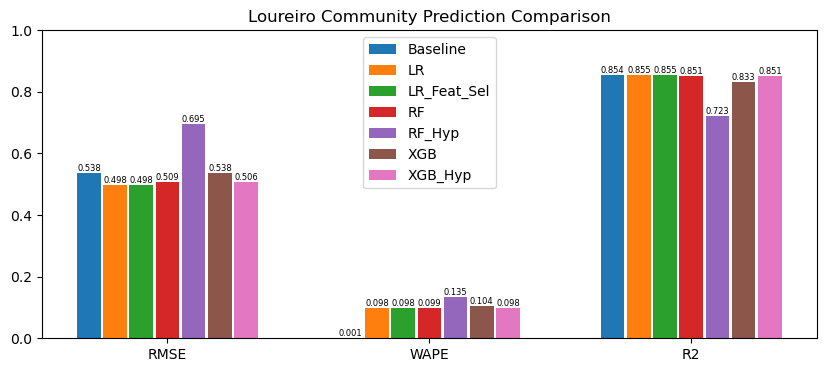

In [83]:
model_names = ("Baseline", "LR", "LR_Feat_Sel", "RF", "RF_Hyp", "XGB", "XGB_Hyp")
X_names = ['RMSE', 'WAPE', 'R2']
X_axis = np.arange(len(X_names))
pos = -0.15
bar_width = 0.1
fig, ax = plt.subplots(figsize=(10,4))

for i in range(len(model_names)):
    bar = (all_rmse[i], all_wape[i], all_r2[i])
    b = ax.bar(X_axis + pos, bar, bar_width-0.01, label=model_names[i])
    pos = pos + bar_width
    ax.bar_label(b, fontsize=6, fmt='%.3f')
    
ax.set_ylim(0,1)
ax.set_xticks(X_axis+bar_width+bar_width/2,X_names)
#ax.set_xlabel("Model Comparison")
#ax.set_ylabel("Metrics")
ax.set_title("Loureiro Community Prediction Comparison")
ax.legend()
#plt.savefig(filename)
plt.show()